# Measuring the relatedness of posts

From a machine learning point of view, raw text is useless. If it is managed to be transformed into meaningful numbers, it can be then feeded into the machine learning algorithms, such as clustering. This is also true for more mundane operations on text, such as similarity measurement.

## How not to do it

One text similarity measure is the Levenshtein distance, which also goes by the name edit distance. For example there are two words, machine and mchiene. The similarity between them can be expressed as the minimum set of edits that are necessary to turn one word into the other. In this case, the edit distance will be two, as an a have to be added after the m and delete the first e. This algorithm is, however, quite costly as it is bound by the length of the first word times the length of the second word.

Looking at the posts, it could be cheated by treating whole words as characters and performing the edit distance calculation on the word level. For example there are two posts called, how to format my hard disk, and hard disk format problems (and assume the post consists only of the title for  simplicity's sake). An edit distance of five will be needed because of removing, how, to, format, my, and then adding format and problems at the end. Thus, one could express the difference between two posts as the number of words that have to be added or deleted so that one text morphs into the other. Although the overall approach could be speeded up quite a bit, the time complexity remains the same.

But even if it would have been fast enough, there is another problem. In the earlier post, the word format accounts for an edit distance of two, due to deleting it first, then adding it. So, the distance seems to be not robust enough to take word reordering into account.

## How to do it

More robust than edit distance is the so-called bag of words approach. For each word in the post, its occurrence is counted and noted in a vector. The previously mentioned two example posts would then have the following word counts:
| Word     | Occurrences in post 1 | Occurrences in post 2 |
| -------- | ----------------------| ----------------------|
| disk     | 1                     | 1                     |
| format   | 1                     | 1                     |
| how      | 1                     | 0                     |
| hard     | 1                     | 1                     |
| my       | 1                     | 0                     |
| problems | 0                     | 1                     |
| to       | 1                     | 0                     |

The columns occurrences in post 2 and occurrences in post 1 can now be treated as vectors. The Euclidean distance between the vectors of all posts can be simply calculated and the nearest one can be taken (too slow, as it has been found out earlier). And as such they can be used later as the feature vectors in the clustering steps, according to the following procedure:
1. Extract salient features from each post and store them as a vector per post
2. Cluster the vectors
3. Determine the cluster for the post in question
4. From this cluster, fetch a handful of posts having a different similarity to the post in question. This will increase diversity

But there is some more work to be done before get there. Before that work can be done, some data is needed to work on.

# Preprocessing – similarity measured as a similar number of common words

As it has been seen earlier, the bag of words approach is both fast and robust. Dive directly into them.

## Converting raw text into a bag of words

It does not have to write custom code for counting words and representing those counts as a vector. Scikit's CountVectorizer method, does the job efficiently but also has a very convenient interface:

In [1]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=1)

The min_df parameter determines how CountVectorizer treats seldom words (minimum document frequency). The instance is printed, It can be seen what other parameters scikit provides together with their default values:

In [2]:
print(vectorizer.get_params())

{'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}


It can be seen that, as expected, the counting is done at the word level (analyzer=word) and words are determined by the regular expression pattern token_pattern. This process is also called tokenization.

Ignore the other parameters for now and consider the following two example subject lines:

In [3]:
content = ["How to format my hard disk", " Hard disk format problems "]

This list of subject lines can be now put into the fit_transform() function of the vectorizer, which does all the hard vectorization work:

In [4]:
X = vectorizer.fit_transform(content)
vectorizer.get_feature_names_out()

array(['disk', 'format', 'hard', 'how', 'my', 'problems', 'to'],
      dtype=object)

The vectorizer has detected seven words for which the counts can be fetched individually:

In [5]:
print(X.toarray().transpose())

[[1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]


This means that the first sentence contains all the words except problems, while the second contains all but how, my, and to. From X, a feature vector that it will be used can be extracted to compare two documents with each other.

Start with a naïve approach first, to point out some preprocessing peculiarities that it has to be accounted for. So pick a random post, for which the count vector will be then created. Its distance will be then compared to all the count vectors and the post with the smallest one will be fetched.

### Counting words

Play with the toy dataset, consisting of the following posts:
| Post filename | Post content                                                                                    |
| ------------- | ----------------------------------------------------------------------------------------------- |
| 01.txt        | This is a toy post about machine learning. Actually, it contains not much interesting stuff     |
| 02.txt        | Imaging databases can get huge                                                                  |
| 03.txt        | Most imaging databases save images permanently                                                  |
| 04.txt        | Imaging databases store images                                                                  |
| 05.txt        | Imaging databases store images. Imaging databases store images. Imaging databases store images. |

In this post dataset, the goal is to find the most similar post for the short post imaging databases.

Assuming that the posts are located in the "data/toy" directory (please check the Jupyter notebook), CountVectorizer can be fed with it:

In [6]:
from pathlib import Path # for easy path management
from sklearn.feature_extraction.text import CountVectorizer

TOY_DIR = Path('./data/toy')
posts = []
for fn in TOY_DIR.iterdir():
    with open(fn, 'r') as f:
        posts.append(f.read())

vectorizer = CountVectorizer(min_df=1)

The vectorizer has to be notified about the full dataset so that it knows upfront which words are to be expected:

In [7]:
X_train = vectorizer.fit_transform(posts)
num_samples, num_features = X_train.shape
print("#samples: {}, #features: {}".format(num_samples, num_features))

#samples: 5, #features: 25


Unsurprisingly, there are five posts with a total of 25 different words. The following words that have been tokenized will be counted:

In [8]:
print(vectorizer.get_feature_names_out())

['about' 'actually' 'capabilities' 'contains' 'data' 'databases' 'images'
 'imaging' 'interesting' 'is' 'it' 'learning' 'machine' 'most' 'much'
 'not' 'permanently' 'post' 'provide' 'save' 'storage' 'store' 'stuff'
 'this' 'toy']


Now the new post can be vectorized:

In [9]:
new_post = "imaging databases"
new_post_vec = vectorizer.transform([new_post])

Note that the count vectors returned by the transform method are sparse, which is the appropriate format because the data itself is also sparse. The new post, for instance, actually contains only two elements:

In [10]:
print(new_post_vec)

  (0, 5)	1
  (0, 7)	1


Via its toarray() member, fully ndarray can be once again accessed:

In [11]:
print(new_post_vec.toarray())

[[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


The full array is needed to be used if the goal is to use it as a vector for similarity calculations. For the similarity measurement (the naïve one), the Euclidean distance between the count vectors of the new post and all the old posts are calculated:

In [12]:
import scipy

def dist_raw(v1, v2):
    delta = v1 - v2
    return scipy.linalg.norm(delta.toarray())

The norm() function calculates the Euclidean norm (shortest distance). This is just one obvious first pick, and there are many more interesting ways to calculate the distance. Just take a look at the paper distance coefficients between two lists or sets in The Python papers source codes, in which Maurice Ling nicely presents 35 different ones.

With dist_raw, it just needs to iterate over all the posts and remember the nearest one. As It will be played throughout the notebook, define a convenience function that takes the current dataset and the new post in vectorized form as well as a distance function and prints out an analysis of how well the distance function works:

In [13]:
def best_post(X, new_vec, dist_func):
    best_doc = None
    best_dist = float('inf') # infinite value as a starting point
    best_i = None
    for i, post in enumerate(posts):
        if post == new_post:
            continue
        post_vec = X.getrow(i)
        d = dist_func(post_vec, new_vec)
        print("=== Post {} with dist={:.2f} \n    '{}'".format(i, d, post))
        if d < best_dist:
            best_dist = d
            best_i = i
    print("n==> Best post is {} with dist={:.2f}".format(best_i, best_dist))

When best_post(X_train, new_post_vec, dist_raw) is executed, it can be seen in the output the posts with their respective distance to the new post:

In [14]:
best_post(X_train, new_post_vec, dist_raw)

=== Post 0 with dist=4.00 
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=1.73 
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=2.00 
    'Most imaging databases save images permanently.'
=== Post 3 with dist=1.41 
    'Imaging databases store data.'
=== Post 4 with dist=5.10 
    'Imaging databases store images. Imaging databases store images. Imaging databases store images.'
n==> Best post is 3 with dist=1.41


Congratulations, the first similarity measurement is done. Post 0 is most dissimilar from the new post. Quite understandably, it does not have a single word in common with the new post. It can be also understood that Post 1 is very similar to the new post, but not the winner, as it contains one word more than Post 3, which is not contained in the new post.

Looking at Post 3 and Post 4, however, the picture is not so clear. Post 4 is the same as Post 3 duplicated three times. So, it should also be as similar to the new post as Post 3.

Printing the corresponding feature vectors explains why:

In [15]:
print(X_train.getrow(3).toarray())
print(X_train.getrow(4).toarray())

[[0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]
[[0 0 0 0 0 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]]


Obviously, using only the counts of the raw words is insufficient. They will have to be normalized to get vectors of unit length.

### Normalizing word count vectors

dist_raw will has to be extended to calculate the vector distance not on the raw vectors but on the normalized ones instead:

In [16]:
def dist_norm(v1, v2):
    v1_normalized = v1 / scipy.linalg.norm(v1.toarray())
    v2_normalized = v2 / scipy.linalg.norm(v2.toarray())
    delta = v1_normalized - v2_normalized
    return scipy.linalg.norm(delta.toarray())

This leads to the following similarity measurement, when being executed with best_post(X_train, new_post_vec, dist_norm):

In [17]:
best_post(X_train, new_post_vec, dist_norm)

=== Post 0 with dist=1.41 
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86 
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.92 
    'Most imaging databases save images permanently.'
=== Post 3 with dist=0.77 
    'Imaging databases store data.'
=== Post 4 with dist=0.77 
    'Imaging databases store images. Imaging databases store images. Imaging databases store images.'
n==> Best post is 3 with dist=0.77


This looks a bit better now. Post 3 and Post 4 are calculated as being equally similar. One could argue whether that much repetition would be a delight to the reader, but in terms of counting the words in the posts this seems to be right.

### Removing less important words

Have another look at Post 2. Of its words that are not in the new post, there are most, save, images, and permanently. They are quite different in the overall importance to the post. The best option would be to remove all the words that are so frequent that they do not help to distinguish between different texts. These words are called stop words.

As this is such a common step in text processing, there is a simple parameter in CountVectorizer to achieve that:

In [18]:
vect_engl = CountVectorizer(min_df=1, stop_words='english')

If there is a clear picture of what kind of stop words would want to be removed, a list of them can be also passed. To find out which ones, get_stop_words() can be used:

In [19]:
sorted(vect_engl.get_stop_words())[0:20]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst']

The new word list is seven words lighter:

In [20]:
X_train_engl = vect_engl.fit_transform(posts)
num_samples_engl, num_features_engl = X_train_engl.shape
print(vect_engl.get_feature_names_out())

['actually' 'capabilities' 'contains' 'data' 'databases' 'images'
 'imaging' 'interesting' 'learning' 'machine' 'permanently' 'post'
 'provide' 'save' 'storage' 'store' 'stuff' 'toy']


After discarding stop words, the current step arrives at the following similarity measurement:

In [21]:
new_post_vec_engl = vect_engl.transform([new_post]) 

best_post(X_train_engl, new_post_vec_engl, dist_norm)

=== Post 0 with dist=1.41 
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86 
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.86 
    'Most imaging databases save images permanently.'
=== Post 3 with dist=0.77 
    'Imaging databases store data.'
=== Post 4 with dist=0.77 
    'Imaging databases store images. Imaging databases store images. Imaging databases store images.'
n==> Best post is 3 with dist=0.77


Post 2 is now on par with Post 1. It has, however, not changed much overall since the posts are kept short for demonstration purposes. It will become vital when it looks at real-world data.

### Stemming

One thing is still missing. Similar words are counted in different variants as different words. It make sense to count them together. After all, it is the same concept they are referring to.

A function that reduces words to their specific word stem is needed. With the Natural Language Toolkit (NLTK), a free software toolkit can be downloaded, which provides a stemmer that it can be easily plugged into CountVectorizer.

#### Installing and using NLTK

NLTK is a simple pip install nltk away.

To check whether the installation was successful, type:

In [22]:
import nltk

NLTK comes with different stemmers. For English, SnowballStemmer can be taken:

In [23]:
import nltk.stem

s = nltk.stem.SnowballStemmer('english')
print(s.stem("graphics"))
print(s.stem("imaging"))
print(s.stem("image"))
print(s.stem("imagination"))
print(s.stem("imagine"))

graphic
imag
imag
imagin
imagin


The stemming does not necessarily have to result in valid English words.

It also works with verbs:

In [24]:
print(s.stem("buys"))
print(s.stem("buying"))

buy
buy


This means it works most of the time:

In [25]:
s.stem("bought")

'bought'

#### Extending the vectorizer with NLTK's stemmer

The posts need to be stemmed before it is feeded into CountVectorizer. The preprocessor and tokenizer can be set as parameters in the constructor. The stemmer will not be placed into any of them, because the tokenization and normalization will then have to be done manually. Instead, the build_analyzer method is overwritten:

In [26]:
import nltk.stem

english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

vect_engl_stem = StemmedCountVectorizer(min_df=1, stop_words='english')

This will do the following process for each post:
1. Lowercase the raw post in the preprocessing step (done in the parent class).
2. Extract all individual words in the tokenization step (done in the parent class).
3. Convert each word into its stemmed version (done in our build_analyzer).

As a result, now there are one less feature, because images and imaging collapsed to one:

In [27]:
X_train_engl_stem = vect_engl_stem.fit_transform(posts)
num_samples_engl_stem, num_features_engl_stem = X_train_engl_stem.shape
print("#samples: {}, #features: {}".format(num_samples_engl_stem,  num_features_engl_stem))
print(vect_engl_stem.get_feature_names_out())

#samples: 5, #features: 17
['actual' 'capabl' 'contain' 'data' 'databas' 'imag' 'interest' 'learn'
 'machin' 'perman' 'post' 'provid' 'save' 'storag' 'store' 'stuff' 'toy']


Running the new stemmed vectorizer over the posts, it is seen that collapsing imaging and images revealed that actually, Post 2 is the most similar post to the new post, as it contains the concept image twice:

In [28]:
new_post_vec_engl_stem = vect_engl_stem.transform([new_post]) 
best_post(X_train_engl_stem, new_post_vec_engl_stem, dist_norm)

=== Post 0 with dist=1.41 
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86 
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.63 
    'Most imaging databases save images permanently.'
=== Post 3 with dist=0.77 
    'Imaging databases store data.'
=== Post 4 with dist=0.52 
    'Imaging databases store images. Imaging databases store images. Imaging databases store images.'
n==> Best post is 4 with dist=0.52


### Stop words on steroids

Now that there is a reasonable way to extract a compact vector from a noisy textual post, step back for a while to think about what the feature values actually mean.

The feature values simply count occurrences of terms in a post. It was silently assumed that higher values for a term also mean that the term is of greater importance to the given post. But what about, for instance, the word subject, which naturally occurs in each and every single post (Subject: ...)? Alright, CountVectorizer can be told to remove it as well by means of its max_df parameter. The problem is that however it is set, there will always be the problem that some terms are just more discriminative than others.

This can only be solved by counting term frequencies for every post and, in addition, discounting those that appear in many posts. In other words, the goal is to obtain a high value for a given term in a given value if that term occurs often in that particular post and very seldom anywhere else.

This is exactly what term frequency - inverse document frequency (TF-IDF) does. TF stands for the counting part, while IDF factors in the discounting. A naïve implementation will look like this:

In [29]:
import numpy as np

def tfidf(term, doc, corpus):
    tf = doc.count(term) / len(doc)
    idf = np.log(float(len(corpus)) / (len([d for d in corpus if term in d])))
    tf_idf = tf * idf
    print("term='{}' doc={} \t tf={:.2f} idf={:.2f} tf*idf={:.2f}".format(term, doc, tf, idf, tf_idf))
    return tf_idf

It can be seen that the terms were not simply counted, but the counts were also normalized by the document length. Of course for fast computation, the IDF calculation would be moved out of the function, since it is the same value for all documents.

For the following documents, D, consisting of three already tokenized documents, it can be seen how the terms are treated differently, although all appear equally often per document:

In [30]:
a, abb, abc = ["a"], ["a", "b", "b"], ["a", "b", "c"]
D = [a, abb, abc]
print("=> tfidf={:.2f}".format(tfidf("a", a, D)))
print("=> tfidf={:.2f}".format(tfidf("a", abb, D)))
print("=> tfidf={:.2f}".format(tfidf("a", abc, D)))
print("=> tfidf={:.2f}".format(tfidf("b", abb, D)))
print("=> tfidf={:.2f}".format(tfidf("b", abc, D)))
print("=> tfidf={:.2f}".format(tfidf("c", abc, D)))

term='a' doc=['a'] 	 tf=1.00 idf=0.00 tf*idf=0.00
=> tfidf=0.00
term='a' doc=['a', 'b', 'b'] 	 tf=0.33 idf=0.00 tf*idf=0.00
=> tfidf=0.00
term='a' doc=['a', 'b', 'c'] 	 tf=0.33 idf=0.00 tf*idf=0.00
=> tfidf=0.00
term='b' doc=['a', 'b', 'b'] 	 tf=0.67 idf=0.41 tf*idf=0.27
=> tfidf=0.27
term='b' doc=['a', 'b', 'c'] 	 tf=0.33 idf=0.41 tf*idf=0.14
=> tfidf=0.14
term='c' doc=['a', 'b', 'c'] 	 tf=0.33 idf=1.10 tf*idf=0.37
=> tfidf=0.37


It is seen that a carries no meaning for any document since it is contained everywhere. The b term is more important for the document abb than for abc as it occurs there twice.

In reality, there are more corner cases to handle than in the preceding example. Thanks to scikit, they don't have to be thought as they are already nicely packaged in TfidfVectorizer, which inherits from CountVectorizer.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

vect_tfidf = StemmedTfidfVectorizer(stop_words='english')

The resulting document vectors will not contain counts any more. Instead, they will contain the individual TF-IDF values per term.

## The achievements and goals

The current text preprocessing phase includes the following steps:
1. Firstly, tokenizing the text
2. This is followed by throwing away words that occur way too often to be of any help in detecting relevant posts
3. Throwing away words that occur so infrequently that there is little chance that they will occur in future posts
4. Counting the remaining words
5. Finally, calculating TF-IDF values from the counts, considering the whole text corpus

Again, congratulations. With this process, it enables to convert a bunch of noisy text into a concise representation of feature values.

But as simple and powerful the bag of words approach with its extensions is, it has some drawbacks, which it should be aware of:
* It does not cover word relations: With the aforementioned vectorization approach, the text, car hits wall and, wall hits car, will both have the same feature vector
* It does not capture negations correctly: For instance, the text, I will eat ice cream, and, I will not eat ice cream, will look very similar by means of their feature vectors although they contain quite the opposite meaning. This problem, however, can easily be mitigated by not only counting individual words, also called unigrams, but instead also considering bigrams (pairs of words) or trigrams (three words in a row)
* It totally fails with misspelled words: Although it is clear that, database, and database convey the same meaning, the approach will treat them as totally different words

For brevity's sake, nevertheless stick with the current approach, which it can be now used to efficiently build clusters.

# Clustering

Finally, the vectors are resulted, which they capture the posts to a sufficient degree. One way to classify clustering algorithms is to distinguish between flat and hierarchical clustering.

Flat clustering divides the posts into a set of clusters without relating the clusters to each other. The goal is simply to come up with a partition such that all posts in one cluster are most similar to each other while being dissimilar from the posts in all other clusters. Many flat clustering algorithms require the number of clusters to be specified up front.

In hierarchical clustering, the number of clusters does not have to be specified. Instead, hierarchical clustering creates a hierarchy of clusters. While similar posts are grouped into one cluster, similar clusters are again grouped into one uber-cluster. In the agglomerative clustering  approach, for instance, this is done recursively until only one cluster is left that contains everything. In this hierarchy, one can then choose the desired number of clusters after the fact. However, this comes at the cost of lower efficiency.

Scikit provides a wide range of clustering approaches in the sklearn.cluster package. A quick overview of advantages and drawbacks of each of them can be obtained at https://scikit-learn.org/stable/modules/clustering.html.

In the following sections, the flat clustering method K-means will be used.

## K-means

K-means is the most widely used flat clustering algorithm. After initializing it with the desired number of clusters, num_clusters, it maintains that number of so-called cluster centroids. Initially, it will pick any num_clusters posts and set the centroids to their feature vector. Then it will go through all other posts and assign them the nearest centroid as their current cluster. Following this, it will move each centroid into the middle of all the vectors of that particular class. This changes, of course, the cluster assignment. Some posts are now nearer to another cluster. So it will update the assignments for those changed posts. This is done as long as the centroids move considerably. After some iterations, the movements will fall below a threshold and clustering is considered to be converged.

Play this out with a toy example of posts containing only two words. Each point in the following chart represents one document:

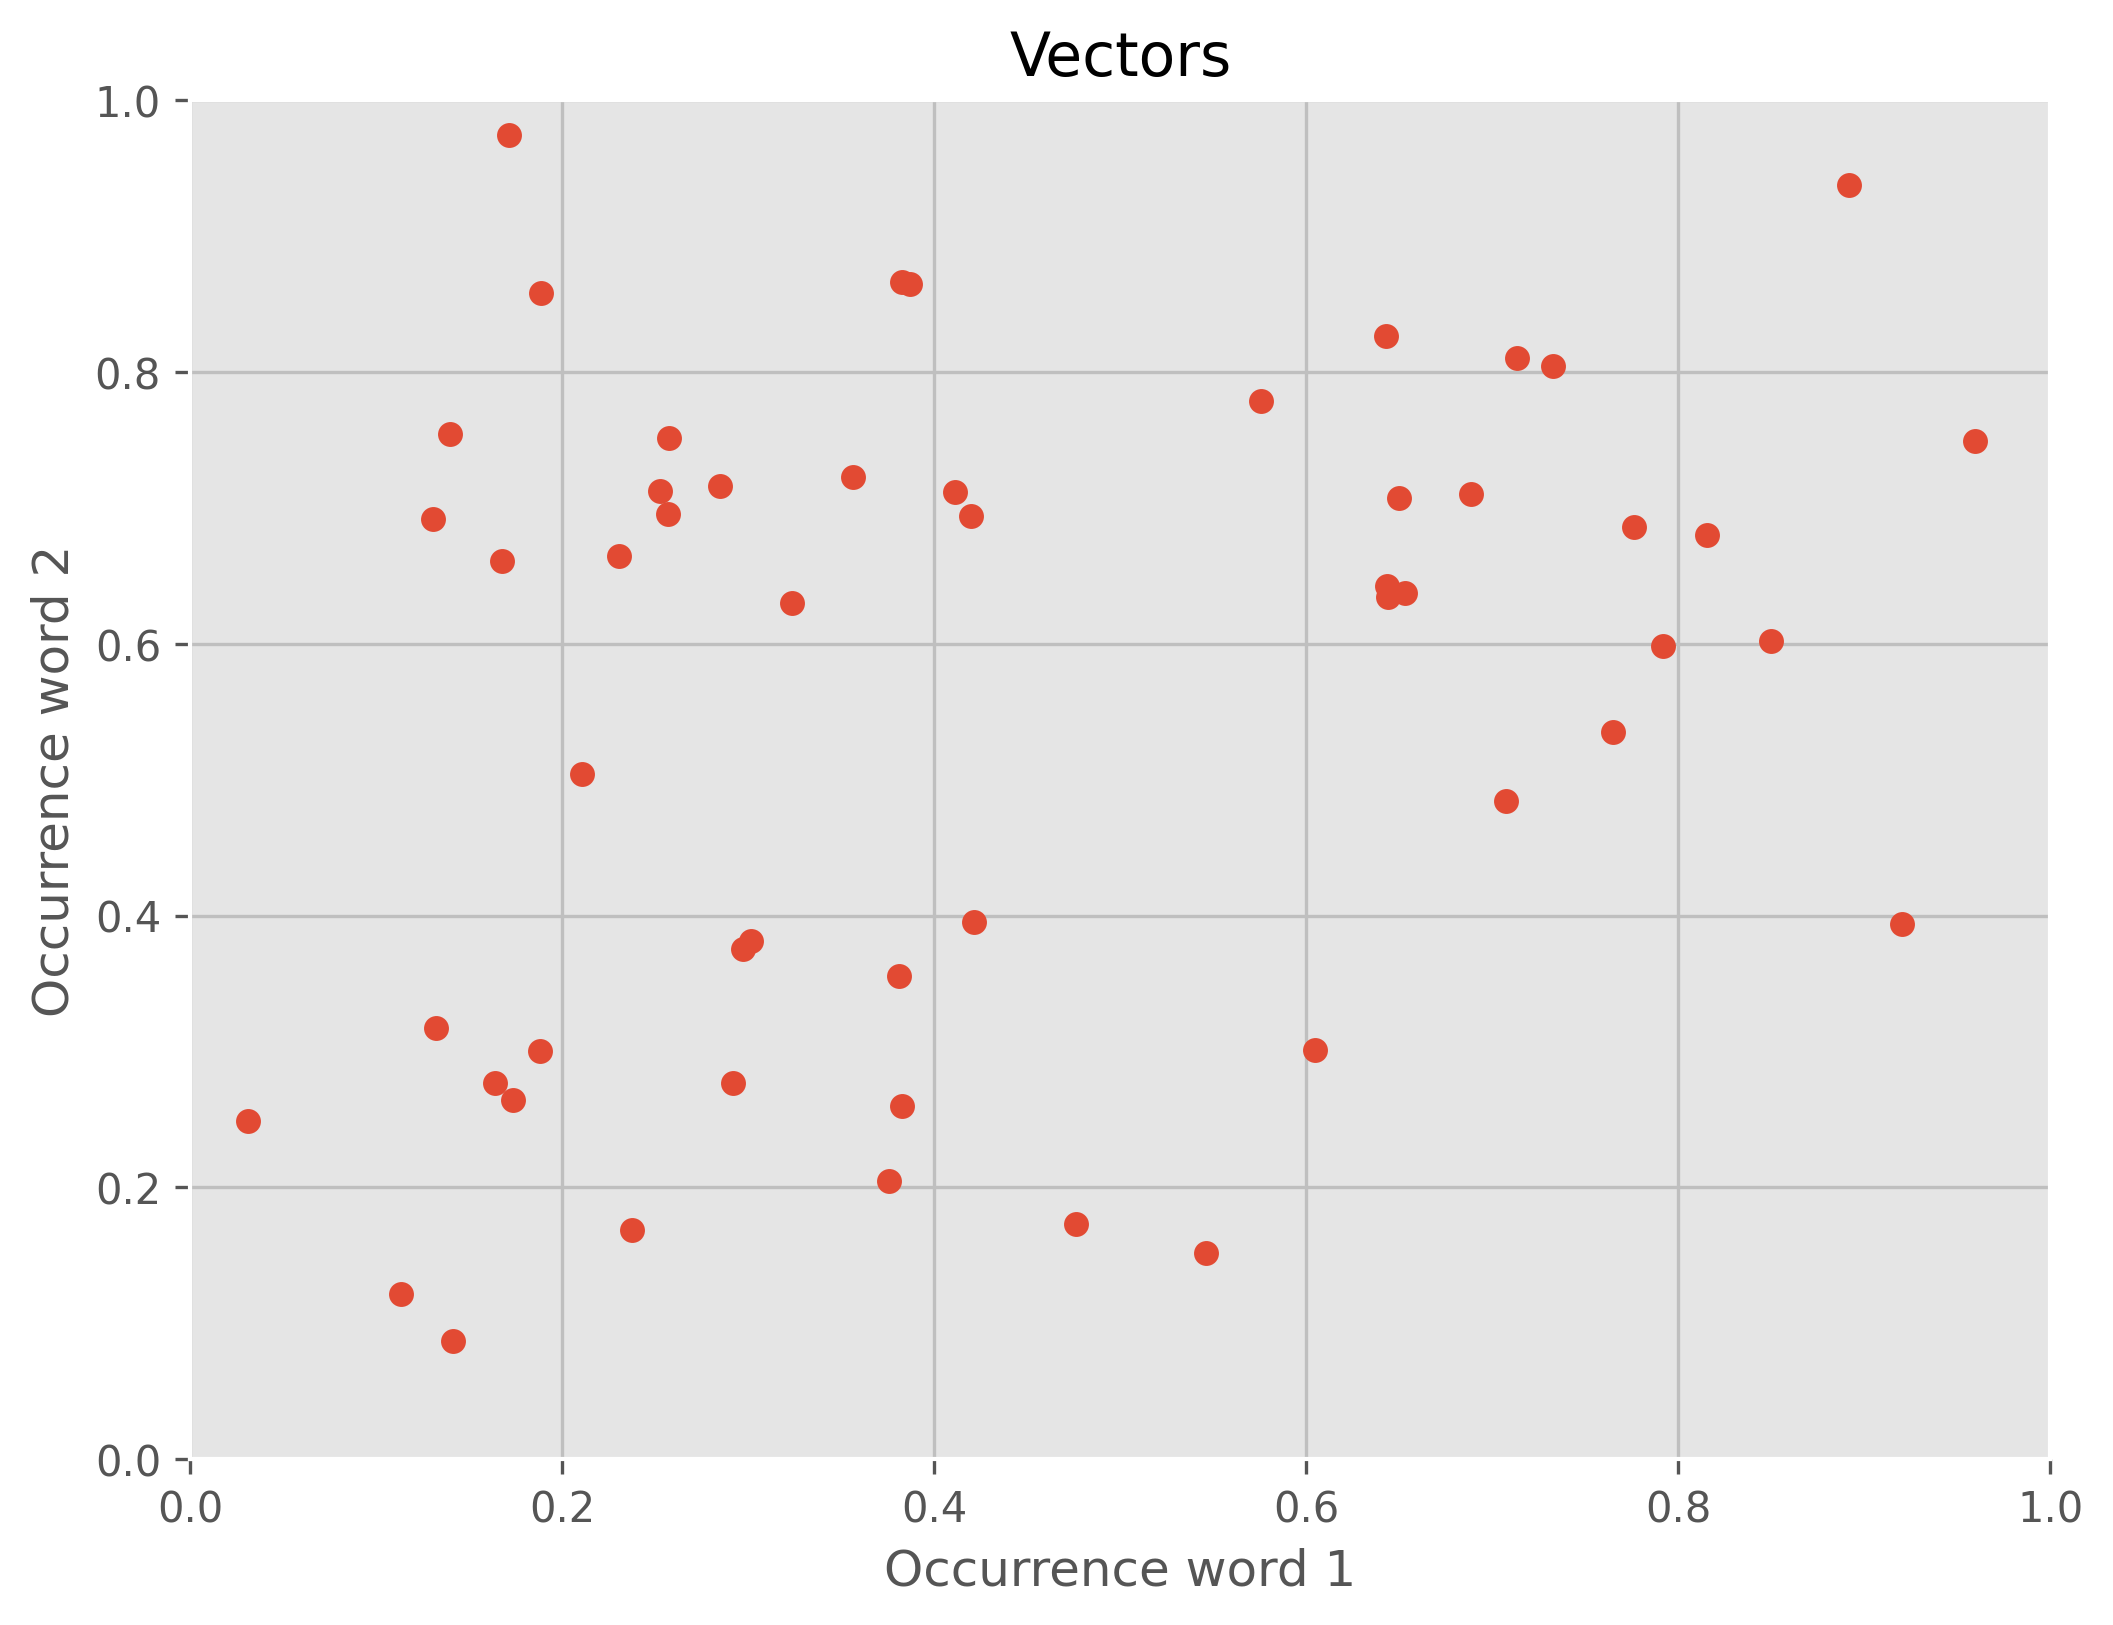

In [32]:
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

DPI = 300

seed = 2
np.random.seed(seed)  # to reproduce the data later on

num_clusters = 3

def plot_clustering(x, y, title, mx=None, ymax=None, xmin=None, km=None):
    plt.figure(num=None, figsize=(8, 6), dpi=DPI)
    if km:
        plt.scatter(x, y, s=30, c=km.predict(list(zip(x, y))))
    else:
        plt.scatter(x, y, s=30)

    plt.title(title)
    plt.xlabel("Occurrence word 1")
    plt.ylabel("Occurrence word 2")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=1)
    plt.grid(True, linestyle='-', color='0.75')

    return plt


xw1 = scipy.stats.norm(loc=0.3, scale=.15).rvs(20)
yw1 = scipy.stats.norm(loc=0.3, scale=.15).rvs(20)

xw2 = scipy.stats.norm(loc=0.7, scale=.15).rvs(20)
yw2 = scipy.stats.norm(loc=0.7, scale=.15).rvs(20)

xw3 = scipy.stats.norm(loc=0.2, scale=.15).rvs(20)
yw3 = scipy.stats.norm(loc=0.8, scale=.15).rvs(20)

x = np.append(np.append(xw1, xw2), xw3)
y = np.append(np.append(yw1, yw2), yw3)

plot_clustering(x, y, "Vectors")
plt.show()

After running one iteration of K-means, that is, taking any two vectors as starting points, assigning the labels to the rest, and updating the cluster centers to be the center point of all points in that cluster, the following clustering is obtained:

Initialization complete
Iteration 0, inertia 4.7485267474116775.


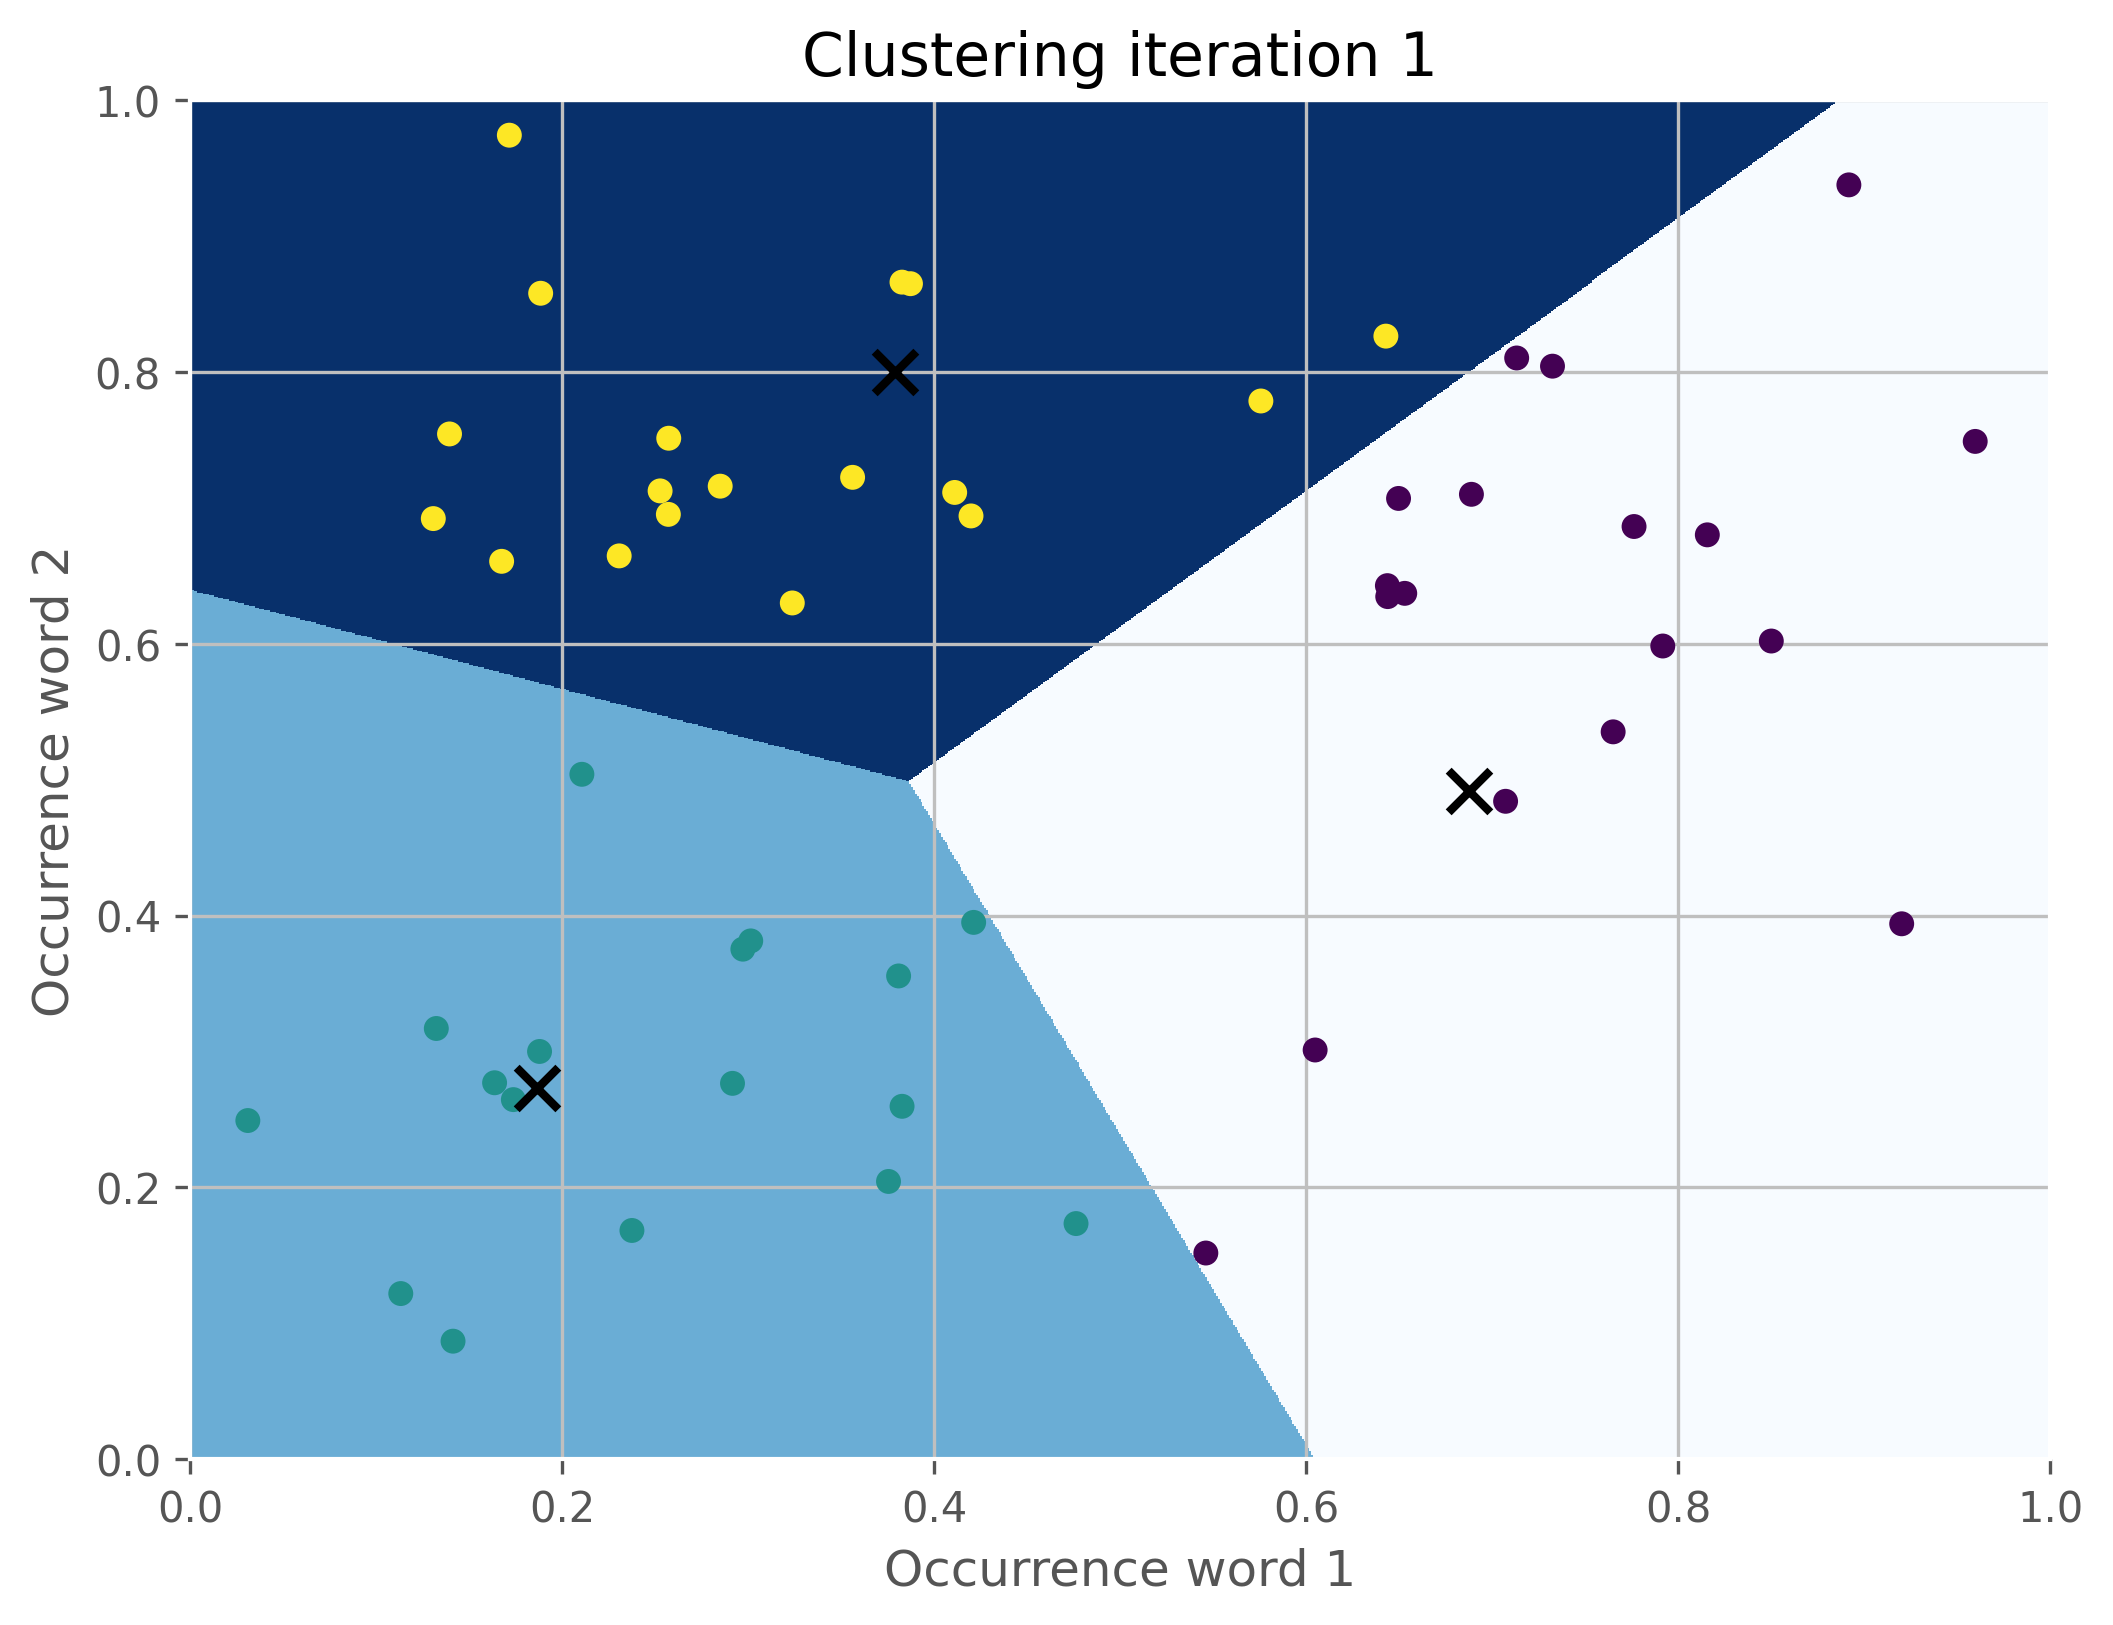

In [33]:
mx, my = np.meshgrid(np.arange(0, 1, 0.001), np.arange(0, 1, 0.001))

km = KMeans(init='random', n_clusters=num_clusters, verbose=1, n_init=1, max_iter=1, random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 1", km=km)
plt.imshow(Z, interpolation='nearest', extent=(mx.min(), mx.max(), my.min(), my.max()), cmap=plt.cm.Blues, aspect='auto', origin='lower')

c1a, c1b, c1c = km.cluster_centers_
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], marker='x', linewidth=2, s=100, color='black')
plt.show()

Because the cluster centers moved, the cluster labels have to be reassigned and the cluster centers have to be recalculated. After iteration 2, the following clustering is obtained:

Initialization complete
Iteration 0, inertia 4.7485267474116775.
Iteration 1, inertia 3.3787856939654475.


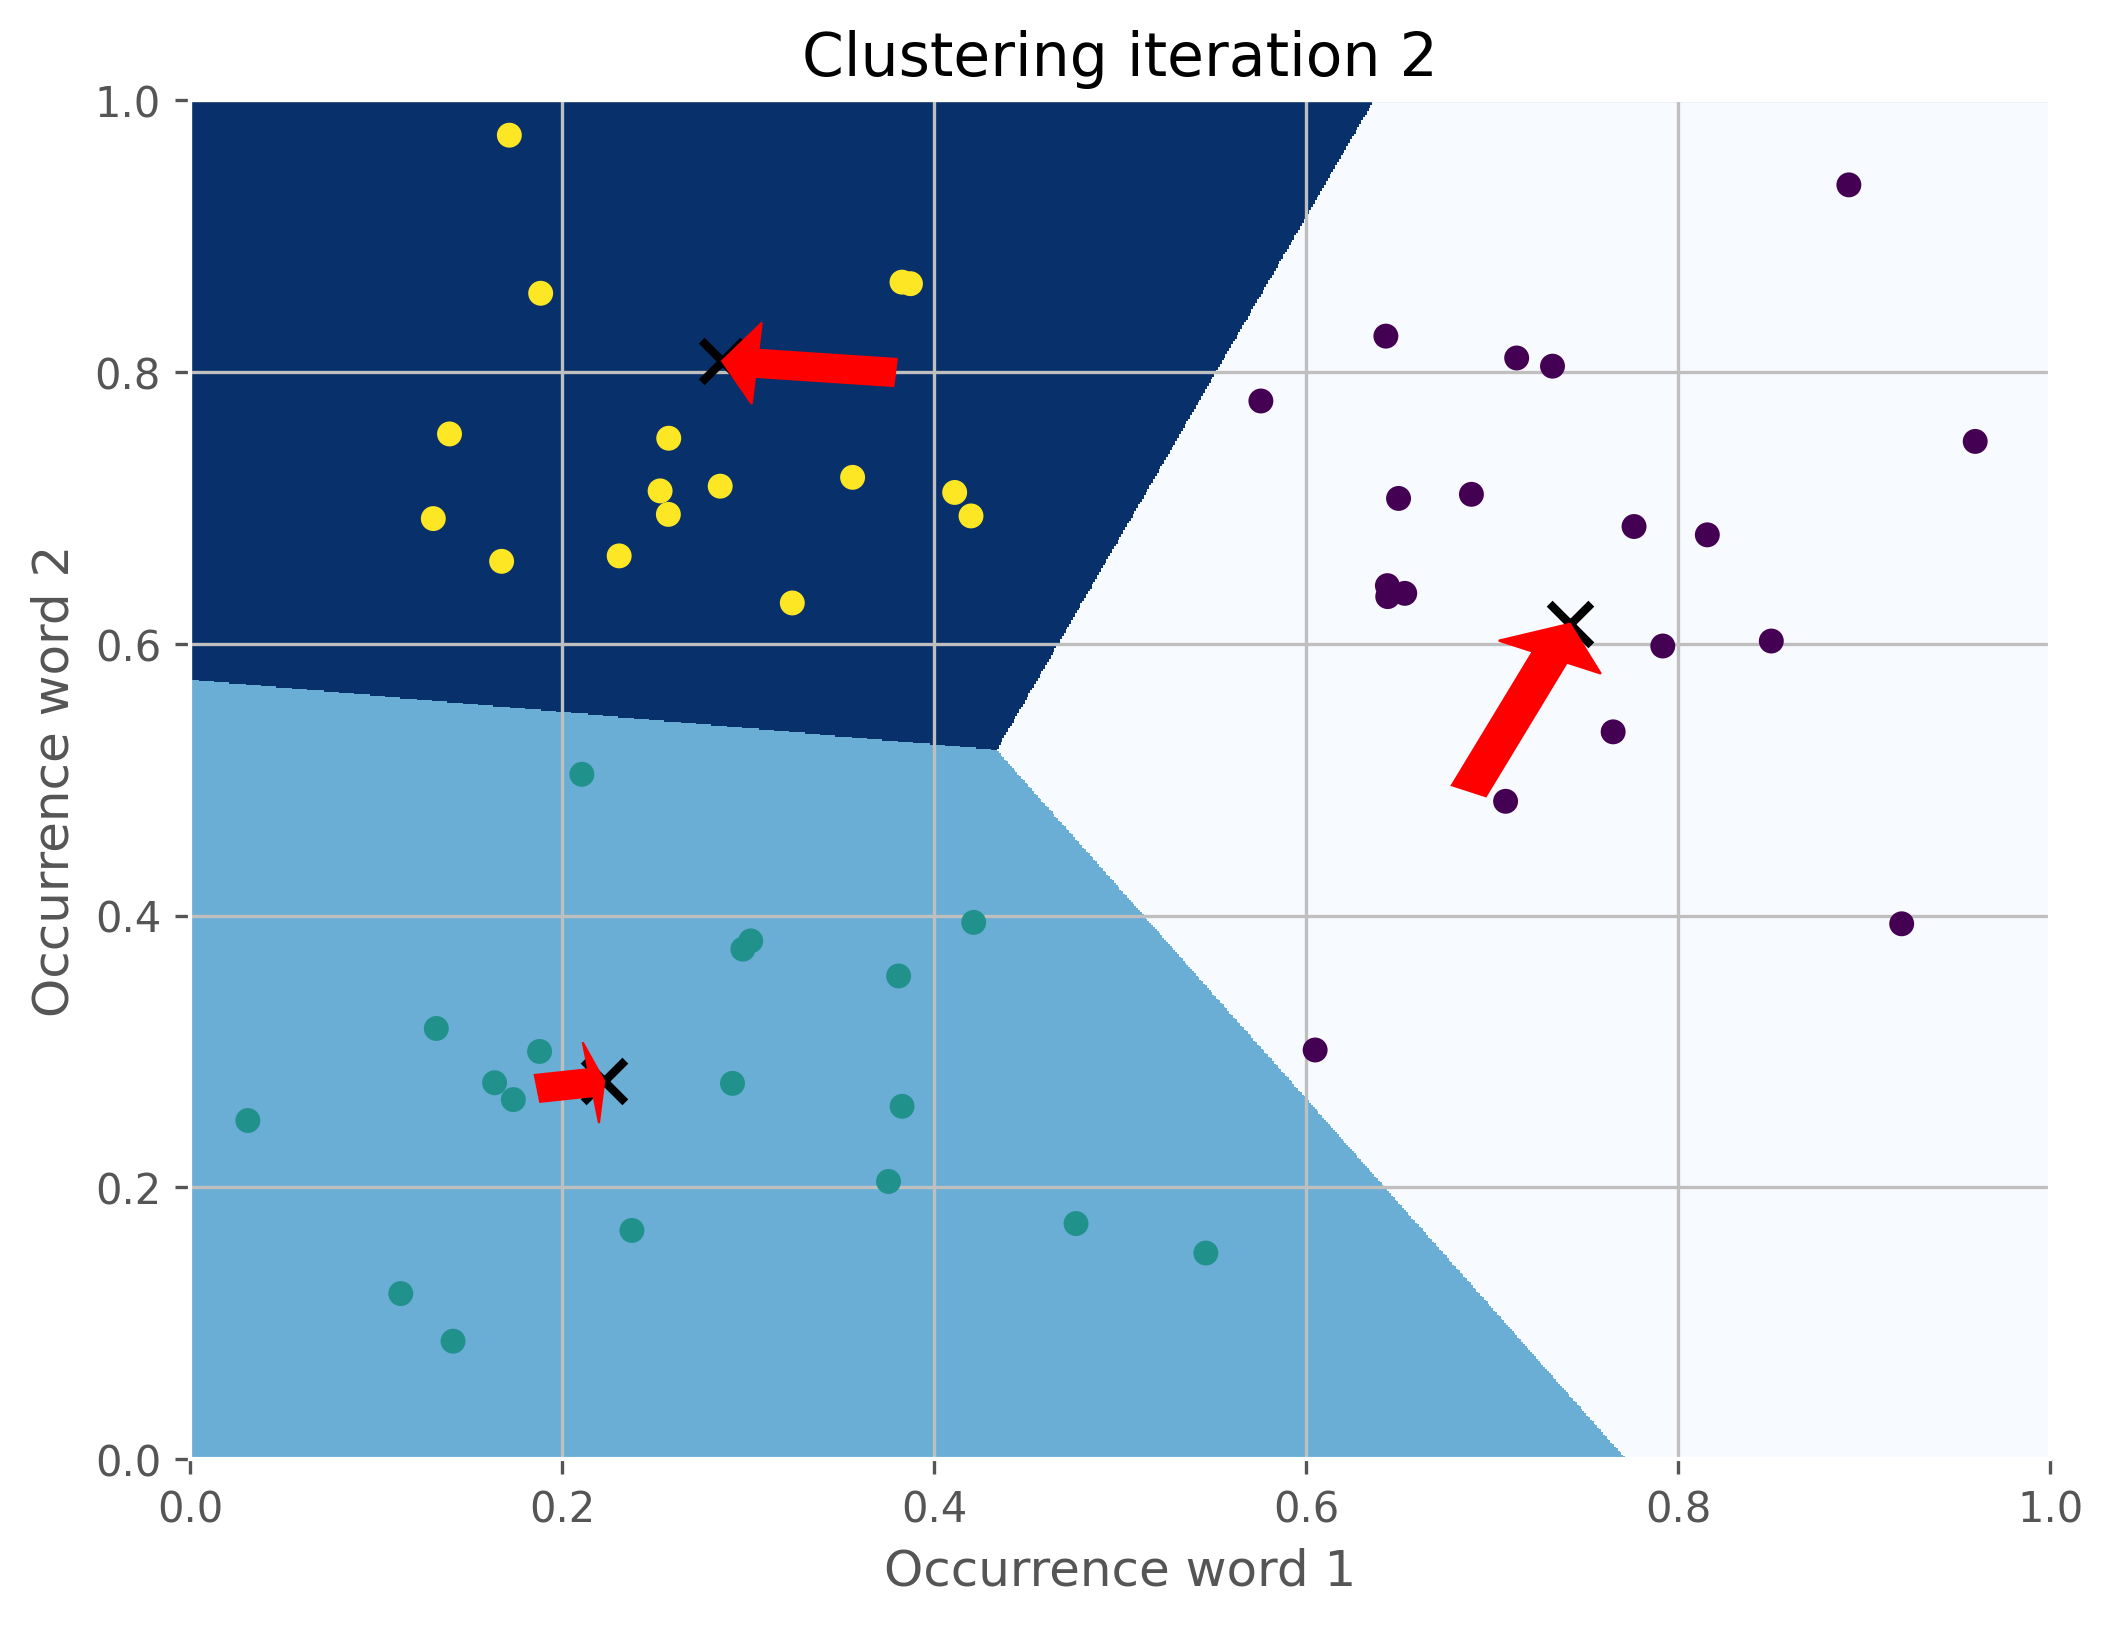

In [34]:
km = KMeans(init='random', n_clusters=num_clusters, verbose=1, n_init=1, max_iter=2, random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 2", km=km)
plt.imshow(Z, interpolation='nearest', extent=(mx.min(), mx.max(), my.min(), my.max()), cmap=plt.cm.Blues, aspect='auto', origin='lower')

c2a, c2b, c2c = km.cluster_centers_
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], marker='x', linewidth=2, s=100, color='black')

plt.gca().add_patch(plt.Arrow(c1a[0], c1a[1], c2a[0] - c1a[0], c2a[1] - c1a[1], width=0.1, color='red'))
plt.gca().add_patch(plt.Arrow(c1b[0], c1b[1], c2b[0] - c1b[0], c2b[1] - c1b[1], width=0.1, color='red'))
plt.gca().add_patch(plt.Arrow(c1c[0], c1c[1], c2c[0] - c1c[0], c2c[1] - c1c[1], width=0.1, color='red'))
plt.show()

The arrows show the movements of the cluster centers. After ten iterations, as shown in the following screenshot of this example, the cluster centers don't move noticeably anymore (scikit's tolerance threshold is 0.0001 by default):

Initialization complete
Iteration 0, inertia 4.7485267474116775.
Iteration 1, inertia 3.3787856939654475.
Iteration 2, inertia 2.5999573206286968.
Iteration 3, inertia 2.496571140237421.
Iteration 4, inertia 2.447223016211801.
Converged at iteration 4: strict convergence.


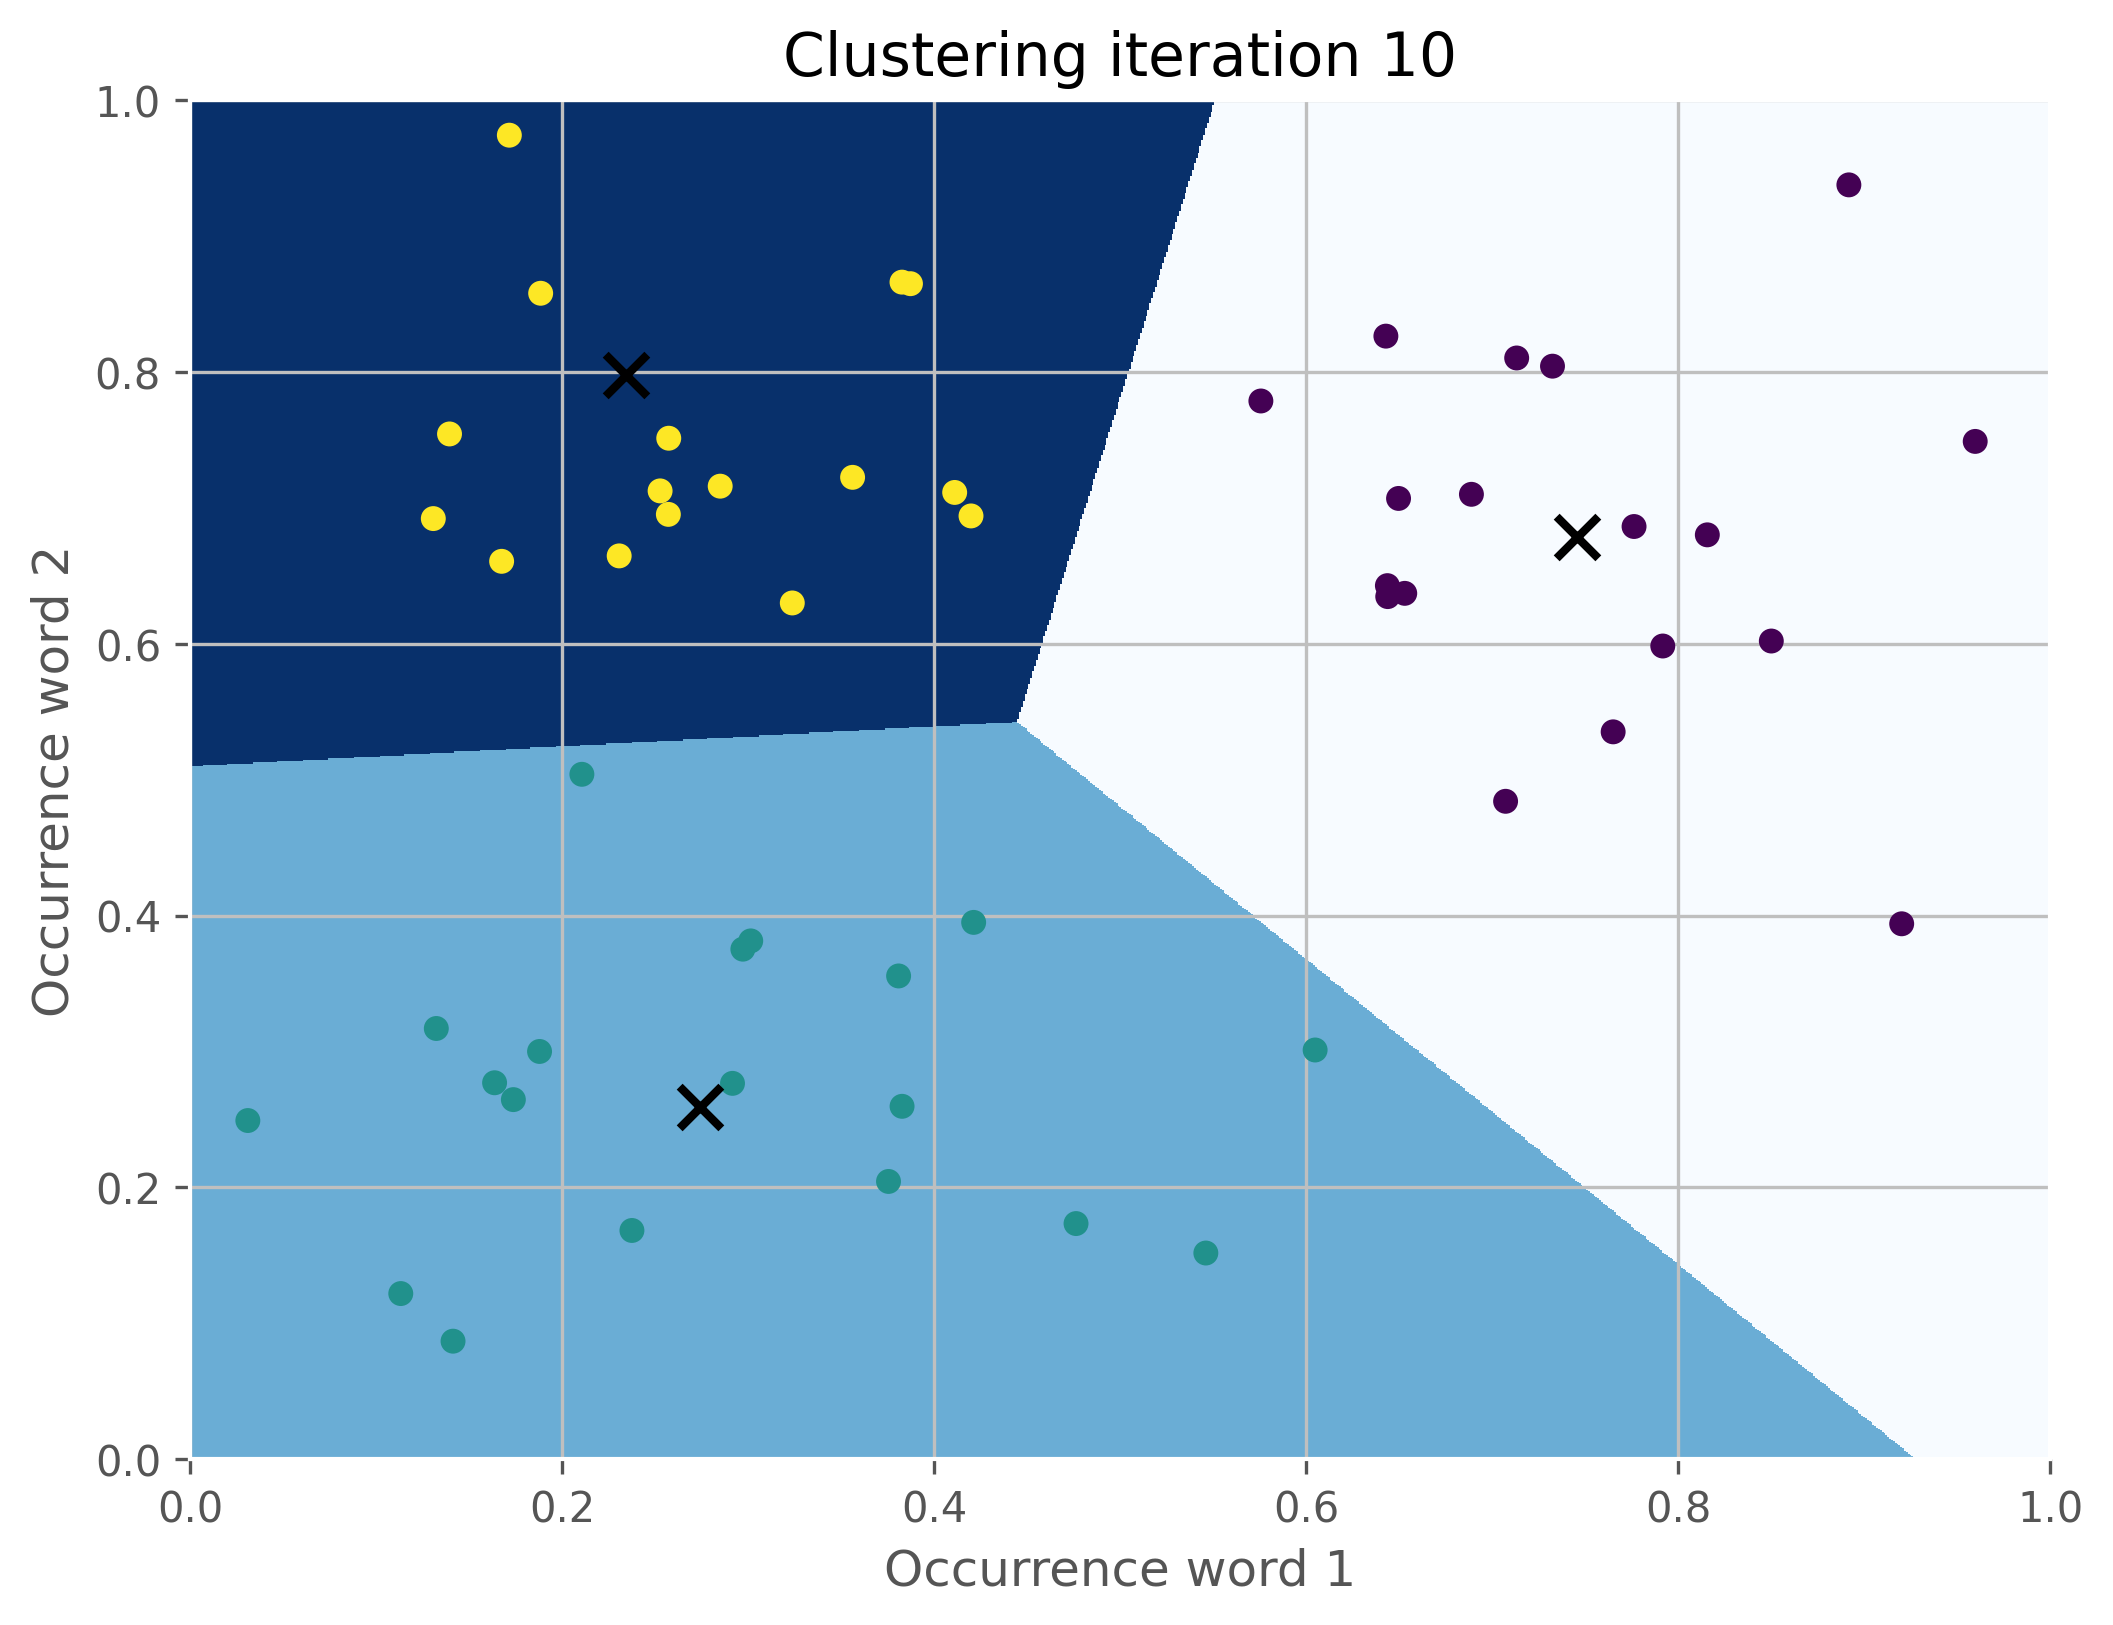

In [35]:
# 10 iterations ####################
km = KMeans(init='random', n_clusters=num_clusters, verbose=1, n_init=1, max_iter=10, random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 10", km=km)
plt.imshow(Z, interpolation='nearest', extent=(mx.min(), mx.max(), my.min(), my.max()), cmap=plt.cm.Blues, aspect='auto', origin='lower')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], marker='x', linewidth=2, s=100, color='black')
plt.show()

After the clustering has settled, note down the cluster centers and their cluster number. For each new document that comes in, it then has to be vectorized and compared against all cluster centers. The cluster center with the smallest distance to the new post vector belongs to the cluster that will be assigned to the new post.

## Getting test data to evaluate the ideas

In order to test clustering, move away from the toy text examples and find a dataset that resembles the data which is being expected in the future so that the approach can be tested. For the purpose, documents about technical topics that are already grouped together are needed so that the algorithm can be checked whether it works as expected when it is applied later to the posts hope to receive.

One standard dataset in machine learning is the 20newsgroup dataset, which contains 18,826 posts from 20 different newsgroups. In this case, it will be restricted to the technical groups. If each newsgroup is assumed as one cluster, the approach of finding related posts can be nicely tested whether it works.

The dataset can be downloaded from http://qwone.com/~jason/20Newsgroups/.

For convenience, the sklearn.datasets module also contains the fetch_20newsgroups function, which automatically downloads the data behind the scenes:

In [36]:
import sklearn.datasets

all_data = sklearn.datasets.fetch_20newsgroups(subset='all')
print(len(all_data.filenames))
print(all_data.target_names)

18846
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


Choose between training and test sets:

In [37]:
train_data = sklearn.datasets.fetch_20newsgroups(subset='train')
print(len(train_data.filenames))

test_data = sklearn.datasets.fetch_20newsgroups(subset='test')
print(len(test_data.filenames))

11314
7532


For simplicity's sake, restrict to only some newsgroups so that the overall experimentation cycle is shorter. This can be achieved with the categories parameter:

In [38]:
groups = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'sci.space']
train_data = sklearn.datasets.fetch_20newsgroups(subset='train', categories=groups)
print(len(train_data.filenames))
test_data = sklearn.datasets.fetch_20newsgroups(subset='test', categories=groups)
print(len(test_data.filenames))

3529
2349


## Clustering posts

One thing has been already noticed—real data is noisy. It even contains invalid characters that will result in UnicodeDecodeError.

Tell the vectorizer to ignore them:

In [39]:
vectorizer = StemmedTfidfVectorizer(min_df=10, max_df=0.5, stop_words='english', decode_error='ignore')
vectorized = vectorizer.fit_transform(train_data.data)
num_samples, num_features = vectorized.shape
print("#samples: {}, #features: {}".format(num_samples, num_features))

#samples: 3529, #features: 4712


A pool of 3529 posts now is obtained and, extracted for each of them, a feature vector of 4712 dimensions. The cluster size will be fixed to 50 for this notebook, and try out different values as an exercise:

In [40]:
from sklearn.cluster import KMeans

num_clusters = 50
km = KMeans(n_clusters=num_clusters, n_init=1, verbose=1, random_state=3)
km.fit(vectorized)

Initialization complete
Iteration 0, inertia 5686.052543663702.
Iteration 1, inertia 3164.8875140123564.
Iteration 2, inertia 3132.2077111951476.
Iteration 3, inertia 3111.7125758781403.
Iteration 4, inertia 3098.583773647865.
Iteration 5, inertia 3092.1905280374394.
Iteration 6, inertia 3087.277089244312.
Iteration 7, inertia 3084.1004773772725.
Iteration 8, inertia 3082.7997677507014.
Iteration 9, inertia 3082.2343826174183.
Iteration 10, inertia 3081.9487984162006.
Iteration 11, inertia 3081.8433339645717.
Iteration 12, inertia 3081.7906650371265.
Iteration 13, inertia 3081.752217763824.
Iteration 14, inertia 3081.6597186798817.
Iteration 15, inertia 3081.6167914695097.
Iteration 16, inertia 3081.5894842981656.
Iteration 17, inertia 3081.57097030357.
Converged at iteration 17: strict convergence.


KMeans(n_clusters=50, n_init=1, random_state=3, verbose=1)

That's it. For every vectorized post that has been fit, there is a corresponding integer label in km.labels_:

In [41]:
print("km.labels_={}".format(km.labels_))
print("km.labels_.shape={}".format(km.labels_.shape))

km.labels_=[48 23 31 ...  6  2 22]
km.labels_.shape=(3529,)


The cluster centers can be accessed via km.cluster_centers_.

In the next section, It will be seen how a cluster can be assigned to a newly arriving post, using km.predict.

# Solving the initial challenge

Everything will be now put together and the system is demonstrated for the following new post that is assigned to the new_post variable:

In [42]:
new_post = ''' Disk drive problems. Hi, I have a problem with my hard disk. After 1 year it is working only 
sporadically now. I tried to format it, but now it doesn't boot any more. Any ideas? Thanks. '''

As learned earlier, first this post has to be vectorized before it is predicted its label:

In [43]:
new_post_vec = vectorizer.transform([new_post])
new_post_label = km.predict(new_post_vec)[0]

Now that the clustering is obtained, it does not need to compare new_post_vec to all post vectors. Fetch their indices in the original data set:

In [44]:
similar_indices = (km.labels_ == new_post_label).nonzero()[0]

The comparison in the bracket results in a Boolean array, and nonzero converts that array into a smaller array containing the indices of the True elements.

Using similar_indices, a list of posts then simply has to be bult together with their similarity scores:

In [45]:
similar = []
for i in similar_indices:
    dist = scipy.linalg.norm((new_post_vec - vectorized[i]).toarray())
    similar.append((dist, train_data.data[i]))
similar = sorted(similar)
print("Count similar: {}".format(len(similar)))

Count similar: 56


56 posts were found in the cluster of the post. To give the user a quick idea of what kind of similar posts are available, the most similar post (show_at_1) and two less similar but still related ones can be now presented, all from the same cluster:

In [46]:
show_at_1 = similar[0]
show_at_2 = similar[len(similar) // 10]
show_at_3 = similar[len(similar) // 2]

The following result shows the posts together with their similarity values:

In [47]:
print("=== #1 ===")
print(show_at_1)
print()

print("=== #2 ===")
print(show_at_2)
print()

print("=== #3 ===")
print(show_at_3)

=== #1 ===
(1.0378441731334074, "From: Thomas Dachsel <GERTHD@mvs.sas.com>\nSubject: BOOT PROBLEM with IDE controller\nNntp-Posting-Host: sdcmvs.mvs.sas.com\nOrganization: SAS Institute Inc.\nLines: 25\n\nHi,\nI've got a Multi I/O card (IDE controller + serial/parallel\ninterface) and two floppy drives (5 1/4, 3 1/2) and a\nQuantum ProDrive 80AT connected to it.\nI was able to format the hard disk, but I could not boot from\nit. I can boot from drive A: (which disk drive does not matter)\nbut if I remove the disk from drive A and press the reset switch,\nthe LED of drive A: continues to glow, and the hard disk is\nnot accessed at all.\nI guess this must be a problem of either the Multi I/o card\nor floppy disk drive settings (jumper configuration?)\nDoes someone have any hint what could be the reason for it.\nPlease reply by email to GERTHD@MVS.SAS.COM\nThanks,\nThomas\n+-------------------------------------------------------------------+\n| Thomas Dachsel                              

It is interesting that the posts reflect the similarity measurement score. The first post contains all the salient words from the new post. The second also revolves around booting problems but is about floppy disks and not hard disks. Finally, the third is neither about hard disks nor about booting problems. Still, all the posts, it would be said, belong to the same domain as the new post.

## Another look at noise

Perfect clustering should not be expected in the sense that posts from the same newsgroup (for example, comp.graphics) are also clustered together. For the sake of simplicity, one of the shorter posts will be focused on: 

In [48]:
post_group = zip(train_data.data, train_data.target)
all = [(len(post[0]), post[0], train_data.target_names[post[1]]) for post in post_group]
graphics = sorted([post for post in all if post[2]=='comp.graphics'])
print(graphics[5])

(245, 'From: SITUNAYA@IBM3090.BHAM.AC.UK\nSubject: test....(sorry)\nOrganization: The University of Birmingham, United Kingdom\nLines: 1\nNNTP-Posting-Host: ibm3090.bham.ac.uk\n\n==============================================================================\n', 'comp.graphics')


For this post, there is no real indication that it belongs to comp.graphics, considering only the wording that is left after the preprocessing step:

In [49]:
noise_post = graphics[5][1]
analyzer = vectorizer.build_analyzer()
print(list(analyzer(noise_post)))

['situnaya', 'ibm3090', 'bham', 'ac', 'uk', 'subject', 'test', 'sorri', 'organ', 'univers', 'birmingham', 'unit', 'kingdom', 'line', 'nntp', 'post', 'host', 'ibm3090', 'bham', 'ac', 'uk']


These words were received after applying tokenization, lowercasing, and stop word removal. If those words that will be later filtered out via min_df and max_df, which will be done later in fit_transform were also subtracted, it gets even worse:

In [50]:
useful = set(analyzer(noise_post)).intersection(vectorizer.get_feature_names_out())
print(sorted(useful))

['ac', 'birmingham', 'host', 'kingdom', 'nntp', 'sorri', 'test', 'uk', 'unit', 'univers']


Most of the words occur frequently in other posts as well, as it can be seen from the IDF scores. Remember that the higher the TF-IDF, the more discriminative a term is for a given post. As IDF is a multiplicative factor here, a low value of it signals that it is not of great value in general:

In [51]:
for term in sorted(useful):
    print('IDF({}) = {:.2f}'.format(term, vectorizer._tfidf.idf_[vectorizer.vocabulary_[term]]))

IDF(ac) = 3.51
IDF(birmingham) = 6.77
IDF(host) = 1.74
IDF(kingdom) = 6.68
IDF(nntp) = 1.77
IDF(sorri) = 4.14
IDF(test) = 3.83
IDF(uk) = 3.70
IDF(unit) = 4.42
IDF(univers) = 1.91


So, the terms with the highest discriminative power, birmingham and kingdom, are clearly not that computer graphics related, as is the case with the terms with lower IDF scores. Understandably, posts from different newsgroups will be clustered together.

For the goal, however, this is no big deal, as it is only interested in cutting down the number of posts that a new post has to be compared to. After all, the particular newsgroup that the training data came from is of no special interest.

# Tweaking the parameters

What about all the other parameters? It could be, for instance, the number of clusters are tweaked, or the vectorizer's max_features parameter is played with (try that!). Also, different cluster center initializations can be played with. Then there are more exciting alternatives to K-means itself. There are, for example, clustering approaches that let different similarity measurements are used, such as Cosine similarity, Pearson, or Jaccard. An exciting field to play.

But before go there, what actually mean by better will have to be defined. Scikit has a complete package dedicated only to this definition. The package is called sklearn.metrics and also contains a full range of different metrics to measure clustering quality. Maybe that should be the first place to go now—right into the sources of the metrics package.